In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as matplotlib
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
from datetime import datetime
import os
import gc
import json
from scipy.optimize import curve_fit
import datetime
from pathlib import Path

In [2]:
pd.options.display.float_format = '{:,.3f}'.format
pd.set_option('display.max_columns', 50)

In [3]:
DATA_DIR_COMMON = '/Users/dcripe/dev/code/notebooks/data_common'
DATA_DIR = '/Users/dcripe/dev/code/notebooks/personal/cv19/data'
OUT_DIR = '/Users/dcripe/dev/code/notebooks/personal/cv19/out'

JHU_TS_DIR = os.path.join(DATA_DIR,'jhu/COVID-19/csse_covid_19_data/csse_covid_19_time_series')
JHU_DR_DIR = os.path.join(DATA_DIR,'jhu/COVID-19/csse_covid_19_data/csse_covid_19_daily_reports')

In [4]:
df_tsc = pd.read_csv(os.path.join(JHU_TS_DIR, 'time_series_covid19_confirmed_global.csv') , sep=',')
df_tsd = pd.read_csv(os.path.join(JHU_TS_DIR, 'time_series_covid19_deaths_global.csv') , sep=',')

In [5]:
df_tsc = df_tsc.rename(columns={'Country/Region': 'country', 'Province/State':'province'})
df_tsd = df_tsd.rename(columns={'Country/Region': 'country', 'Province/State':'province'})

In [6]:
df_pop = pd.read_csv(os.path.join(DATA_DIR_COMMON, 'world_pop_2020.csv'), sep=',')

In [7]:
df_pop.head()

,rank,country,population,yearly_change,net_change,density,land_area_km2,migrants_net,fert_rate,med_age,urban_pop_%,world_share,country_code
0,37,Afghanistan,38928346,0.023,886592,60.000,"652,860.000","-62,920.000",4.600,18.000,0.250,0.005,AF
1,140,Albania,2877797,-0.001,-3120,105.000,"27,400.000","-14,000.000",1.600,36.000,0.630,0.000,AL
2,33,Algeria,43851044,0.018,797990,18.000,"2,381,740.000","-10,000.000",3.100,29.000,0.730,0.006,DZ
3,210,American Samoa,55191,-0.002,-121,276.000,200.000,nan,nan,nan,0.880,nan,AS
4,203,Andorra,77265,0.002,123,164.000,470.000,nan,nan,nan,0.880,nan,AD


In [8]:
df_tsd['country'] = df_tsd['country'].replace("US", "United States")
df_tsd['country'] = df_tsd['country'].replace("Korea, South", "South Korea")
df_tsd['country'] = df_tsd['country'].replace("Taiwan*", "Taiwan")
df_tsc['country'] = df_tsc['country'].replace("US", "United States")
df_tsc['country'] = df_tsc['country'].replace("Korea, South", "South Korea")
df_tsc['country'] = df_tsc['country'].replace("Taiwan*", "Taiwan")

In [9]:
df_tsdg = df_tsd.groupby('country').sum().drop(['Lat','Long'], axis=1).stack().swaplevel(0,1)
df_tscg = df_tsc.groupby('country').sum().drop(['Lat','Long'], axis=1).stack().swaplevel(0,1)
# df_tsrg = df_tsr.groupby('Country/Region').sum().drop(['Lat','Long'], axis=1).stack().swaplevel(0,1)

In [10]:
df_tsdg.head()

         country    
1/22/20  Afghanistan    0
1/23/20  Afghanistan    0
1/24/20  Afghanistan    0
1/25/20  Afghanistan    0
1/26/20  Afghanistan    0
dtype: int64

In [11]:
set(df_tsd['country'].unique()) - set(df_pop['country'].unique())

{'Burma',
 'Congo (Brazzaville)',
 'Congo (Kinshasa)',
 'Diamond Princess',
 'Kosovo',
 'MS Zaandam',
 'Saint Kitts and Nevis',
 'Saint Vincent and the Grenadines',
 'Sao Tome and Principe',
 'West Bank and Gaza'}

In [12]:
df_tsdg.head()

         country    
1/22/20  Afghanistan    0
1/23/20  Afghanistan    0
1/24/20  Afghanistan    0
1/25/20  Afghanistan    0
1/26/20  Afghanistan    0
dtype: int64

In [13]:
print("date range: {0} - {1}".format(df_tscg.index.levels[0][0], df_tscg.index.levels[0][-1]))

date range: 1/22/20 - 4/17/20


In [14]:
top_25 = df_tsdg.unstack().iloc[-1].sort_values(ascending=False)[0:25].index.values
top_10 = df_tsdg.unstack().iloc[-1].sort_values(ascending=False)[0:10].index.values

In [15]:
top_25

array(['United States', 'Italy', 'Spain', 'France', 'United Kingdom',
       'Belgium', 'Iran', 'China', 'Germany', 'Netherlands', 'Brazil',
       'Turkey', 'Sweden', 'Canada', 'Switzerland', 'Portugal', 'Ireland',
       'Indonesia', 'India', 'Mexico', 'Austria', 'Ecuador', 'Romania',
       'Philippines', 'Algeria'], dtype=object)

In [16]:
df_countries = pd.DataFrame(data=df_tsd['country'].unique(), columns=['country'])
df_countries = df_countries.merge(df_pop, how='left', left_on='country', right_on='country')
df_countries.index = df_countries['country']
df_countries.drop('country', axis=1, inplace=True)

In [17]:
df_countries.head()

,rank,population,yearly_change,net_change,density,land_area_km2,migrants_net,fert_rate,med_age,urban_pop_%,world_share,country_code
country,,,,,,,,,,,,
Afghanistan,37.000,"38,928,346.000",0.023,"886,592.000",60.000,"652,860.000","-62,920.000",4.600,18.000,0.250,0.005,AF
Albania,140.000,"2,877,797.000",-0.001,"-3,120.000",105.000,"27,400.000","-14,000.000",1.600,36.000,0.630,0.000,AL
Algeria,33.000,"43,851,044.000",0.018,"797,990.000",18.000,"2,381,740.000","-10,000.000",3.100,29.000,0.730,0.006,DZ
Andorra,203.000,"77,265.000",0.002,123.000,164.000,470.000,nan,nan,nan,0.880,nan,AD
Angola,44.000,"32,866,272.000",0.033,"1,040,977.000",26.000,"1,246,700.000","6,413.000",5.600,17.000,0.670,0.004,AO


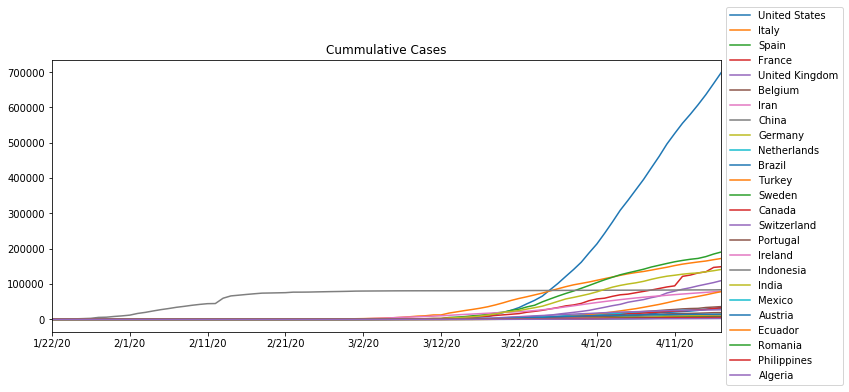

In [18]:
df_tscg.unstack()[top_25].plot.line(title='Cummulative Cases', figsize=(12,5)).legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

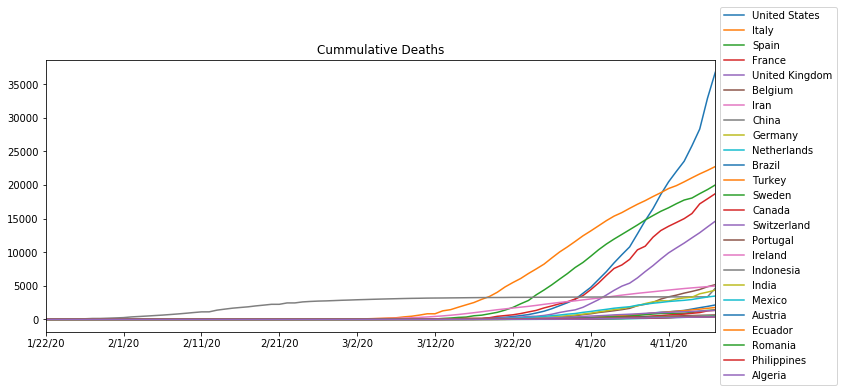

In [19]:
df_tsdg.unstack()[top_25].plot.line(title='Cummulative Deaths', figsize=(12,5)).legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

In [20]:
df_c = pd.DataFrame(index=df_tscg.index, data=df_tscg, columns=['confirmed'])
df_c['deaths'] = df_tsdg


In [21]:
df_c = df_c.stack().swaplevel(0,1).unstack()
df_c[['new_confirmed', 'new_deaths']] = df_c[['confirmed', 'deaths']].diff()
df_c = df_c.stack().swaplevel(0,1).unstack()

In [22]:
df_c.head()

confirmed  deaths  new_confirmed  new_deaths
        country                                                  
1/22/20 Afghanistan      0.000   0.000            nan         nan
        Albania          0.000   0.000       -906.000     -30.000
        Algeria          0.000   0.000       -539.000     -26.000
        Andorra          0.000   0.000     -2,418.000    -364.000
        Angola           0.000   0.000       -696.000     -35.000

In [23]:
df_c.stack().swaplevel(1,2).unstack().unstack().head()

country Afghanistan                                   Albania         \
          confirmed deaths new_confirmed new_deaths confirmed deaths   
1/22/20       0.000  0.000           nan        nan     0.000  0.000   
1/23/20       0.000  0.000         0.000      0.000     0.000  0.000   
1/24/20       0.000  0.000         0.000      0.000     0.000  0.000   
1/25/20       0.000  0.000         0.000      0.000     0.000  0.000   
1/26/20       0.000  0.000         0.000      0.000     0.000  0.000   

country                            Algeria                                  \
        new_confirmed new_deaths confirmed deaths new_confirmed new_deaths   
1/22/20      -906.000    -30.000     0.000  0.000      -539.000    -26.000   
1/23/20         0.000      0.000     0.000  0.000         0.000      0.000   
1/24/20         0.000      0.000     0.000  0.000         0.000      0.000   
1/25/20         0.000      0.000     0.000  0.000         0.000      0.000   
1/26/20         0.000      0.000     0.000  0.000         0.000      0.000   

country   Andorra                                    Angola         \
        confirmed deaths new_confirmed new_deaths confirmed deaths   
1/22/20     0.000  0.000    -2,418.000   -364.000     0.000  0.000   
1/23/20     0.000  0.000         0.000      0.000     0.000  0.000   
1/24/20     0.000  0.000         0.000      0.000     0.000  0.000   
1/25/20     0.000  0.000         0.000      0.000     0.000  0.000   
1/26/20     0.000  0.000         0.000      0.000     0.000  0.000   

country                          Antigua and Barbuda                       \
        new_confirmed new_deaths           confirmed deaths new_confirmed   
1/22/20      -696.000    -35.000               0.000  0.000       -19.000   
1/23/20         0.000      0.000               0.000  0.000         0.000   
1/24/20         0.000      0.000               0.000  0.000         0.000   
1/25/20         0.000      0.000               0.000  0.000         0.000   
1/26/20         0.000      0.000               0.000  0.000         0.000   

country            Argentina  ...  Venezuela   Vietnam                       \
        new_deaths confirmed  ... new_deaths confirmed deaths new_confirmed   
1/22/20     -2.000     0.000  ...     -4.000     0.000  0.000      -204.000   
1/23/20      0.000     0.000  ...      0.000     2.000  0.000         2.000   
1/24/20      0.000     0.000  ...      0.000     2.000  0.000         0.000   
1/25/20      0.000     0.000  ...      0.000     2.000  0.000         0.000   
1/26/20      0.000     0.000  ...      0.000     2.000  0.000         0.000   

country            West Bank and Gaza                                  \
        new_deaths          confirmed deaths new_confirmed new_deaths   
1/22/20     -9.000              0.000  0.000      -268.000      0.000   
1/23/20      0.000              0.000  0.000         0.000      0.000   
1/24/20      0.000              0.000  0.000         0.000      0.000   
1/25/20      0.000              0.000  0.000         0.000      0.000   
1/26/20      0.000              0.000  0.000         0.000      0.000   

country Western Sahara                                     Yemen         \
             confirmed deaths new_confirmed new_deaths confirmed deaths   
1/22/20          0.000  0.000      -402.000     -2.000     0.000  0.000   
1/23/20          0.000  0.000         0.000      0.000     0.000  0.000   
1/24/20          0.000  0.000         0.000      0.000     0.000  0.000   
1/25/20          0.000  0.000         0.000      0.000     0.000  0.000   
1/26/20          0.000  0.000         0.000      0.000     0.000  0.000   

country                             Zambia                                  \
        new_confirmed new_deaths confirmed deaths new_confirmed new_deaths   
1/22/20        -6.000      0.000     0.000  0.000        -1.000      0.000   
1/23/20         0.000      0.000     0.000  0.000         0.000      0.000   
1/24/20      

In [24]:
df_countries['conf_10_idx'] = 0
df_countries['conf_10_date'] = 0
df_countries['death_10_idx'] = 0
df_countries['death_10_date'] = 0

In [25]:
df_countries.head()

,rank,population,yearly_change,net_change,density,land_area_km2,migrants_net,fert_rate,med_age,urban_pop_%,world_share,country_code,conf_10_idx,conf_10_date,death_10_idx,death_10_date
country,,,,,,,,,,,,,,,,
Afghanistan,37.000,"38,928,346.000",0.023,"886,592.000",60.000,"652,860.000","-62,920.000",4.600,18.000,0.250,0.005,AF,0,0,0,0
Albania,140.000,"2,877,797.000",-0.001,"-3,120.000",105.000,"27,400.000","-14,000.000",1.600,36.000,0.630,0.000,AL,0,0,0,0
Algeria,33.000,"43,851,044.000",0.018,"797,990.000",18.000,"2,381,740.000","-10,000.000",3.100,29.000,0.730,0.006,DZ,0,0,0,0
Andorra,203.000,"77,265.000",0.002,123.000,164.000,470.000,nan,nan,nan,0.880,nan,AD,0,0,0,0
Angola,44.000,"32,866,272.000",0.033,"1,040,977.000",26.000,"1,246,700.000","6,413.000",5.600,17.000,0.670,0.004,AO,0,0,0,0


In [26]:
np.where(df_c.xs('United States', level=1, drop_level=False)['deaths'] > 10)[0][0]

42

In [27]:
df_c.xs('United States', level=1, drop_level=False).iloc[42].name[0]

'3/4/20'

In [29]:
def get_tens_for_country(country, df):
#     print('processing {0}'.format(country))
    if (df_c.xs(country, level=1, drop_level=False)['confirmed'].max() >= 10) & (len(np.where(df_c.xs(country, level=1, drop_level=False)['confirmed'] >= 10))>0):
        conf_10_idx = np.where(df_c.xs(country, level=1, drop_level=False)['confirmed'] >= 10)[0][0]
        conf_10_date = df_c.xs(country, level=1, drop_level=False).iloc[conf_10_idx].name[0]
    else:
        conf_10_idx = np.NaN
        conf_10_date = None
                
#     print(df_c.xs(country, level=1, drop_level=False)['deaths'].max())
    if (df_c.xs(country, level=1, drop_level=False)['deaths'].max() >= 10) & (len(np.where(df_c.xs(country, level=1, drop_level=False)['deaths'] >= 10))>0):
#         print(np.where(df_c.xs(country, level=1, drop_level=False)['deaths'] > 10))
        death_10_idx = np.where(df_c.xs(country, level=1, drop_level=False)['deaths'] >= 10)[0][0]
        death_10_date = df_c.xs(country, level=1, drop_level=False).iloc[death_10_idx].name[0]
    else:
        death_10_idx = np.NaN
        death_10_date = None

    return (conf_10_idx, conf_10_date, death_10_idx, death_10_date)

In [30]:
get_tens_for_country('United States', df_c)

(12, '2/3/20', 42, '3/4/20')

In [31]:
df_countries.apply(lambda x: get_tens_for_country(x.name, df_c), axis=1)

country
Afghanistan               (52, 3/14/20, 75, 4/6/20)
Albania                  (48, 3/10/20, 66, 3/28/20)
Algeria                   (42, 3/4/20, 58, 3/20/20)
Andorra                  (55, 3/17/20, 69, 3/31/20)
Angola                      (73, 4/4/20, nan, None)
                                    ...            
Malawi                     (80, 4/11/20, nan, None)
South Sudan                  (nan, None, nan, None)
Western Sahara               (nan, None, nan, None)
Sao Tome and Principe        (nan, None, nan, None)
Yemen                        (nan, None, nan, None)
Length: 185, dtype: object

In [32]:
df_countries[['conf_10_idx', 'conf_10_date', 'death_10_idx', 'death_10_date']] = df_countries.apply(lambda x: get_tens_for_country(x.name, df_c), axis=1, result_type='expand')

In [33]:
df_countries.head()

,rank,population,yearly_change,net_change,density,land_area_km2,migrants_net,fert_rate,med_age,urban_pop_%,world_share,country_code,conf_10_idx,conf_10_date,death_10_idx,death_10_date
country,,,,,,,,,,,,,,,,
Afghanistan,37.000,"38,928,346.000",0.023,"886,592.000",60.000,"652,860.000","-62,920.000",4.600,18.000,0.250,0.005,AF,52.000,3/14/20,75.000,4/6/20
Albania,140.000,"2,877,797.000",-0.001,"-3,120.000",105.000,"27,400.000","-14,000.000",1.600,36.000,0.630,0.000,AL,48.000,3/10/20,66.000,3/28/20
Algeria,33.000,"43,851,044.000",0.018,"797,990.000",18.000,"2,381,740.000","-10,000.000",3.100,29.000,0.730,0.006,DZ,42.000,3/4/20,58.000,3/20/20
Andorra,203.000,"77,265.000",0.002,123.000,164.000,470.000,nan,nan,nan,0.880,nan,AD,55.000,3/17/20,69.000,3/31/20
Angola,44.000,"32,866,272.000",0.033,"1,040,977.000",26.000,"1,246,700.000","6,413.000",5.600,17.000,0.670,0.004,AO,73.000,4/4/20,nan,None


In [34]:
0 - df_countries.loc['United States']['death_10_idx']

-42.0

In [35]:
df_c.xs('United States', level=1).shift(periods=int(0 - df_countries.loc['United States']['death_10_idx']))

,confirmed,deaths,new_confirmed,new_deaths
1/22/20,149.000,11.000,31.000,4.000
1/23/20,217.000,12.000,68.000,1.000
1/24/20,262.000,14.000,45.000,2.000
1/25/20,402.000,17.000,140.000,3.000
1/26/20,518.000,21.000,116.000,4.000
...,...,...,...,...
4/13/20,nan,nan,nan,nan
4/14/20,nan,nan,nan,nan
4/15/20,nan,nan,nan,nan
4/16/20,nan,nan,nan,nan


In [36]:
clist = top_10
norm = 'United States'
df_comp = pd.DataFrame(data={
#     c:df_c.xs(c, level=1)['deaths'] for c in top_10
    c:df_c.xs(c, level=1).shift(periods=int(0 - df_countries.loc[c]['death_10_idx']))['deaths'] for c in top_10
})
for c in top_10:
    df_comp[c] = df_comp[c] * (df_countries.loc[norm]['population']/df_countries.loc[c]['population'])
df_comp = df_comp.reset_index().drop('index', axis=1)

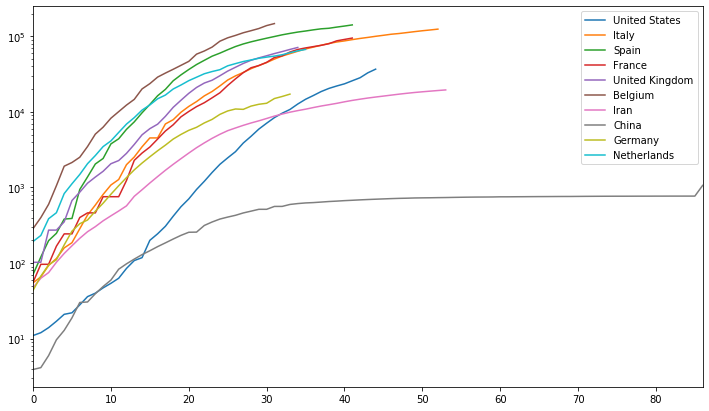

In [37]:
df_comp.plot.line(figsize=(12,7), logy=True)

In [39]:
# df_countries[df_countries['country'] == 'Germany']

In [40]:
df_comp = df_c[['confirmed','deaths']].stack().swaplevel(1,2).unstack()[['Germany','United States']].unstack()

In [41]:
df_comp['United States'] = df_comp['United States'] * 83.7/331

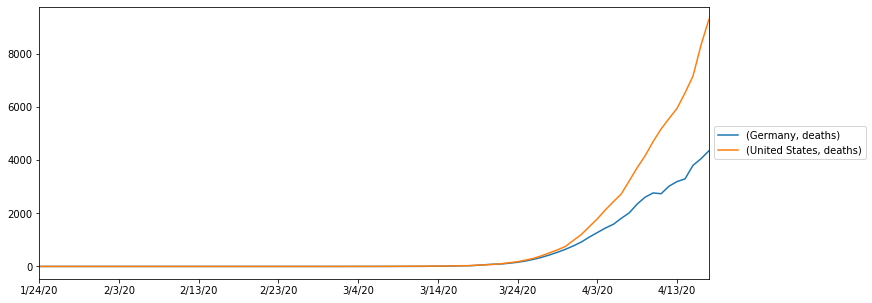

In [51]:
df_comp[[('Germany','deaths'),('United States','deaths')]].iloc[2::].plot.line(figsize=(12,5), logy=False).legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

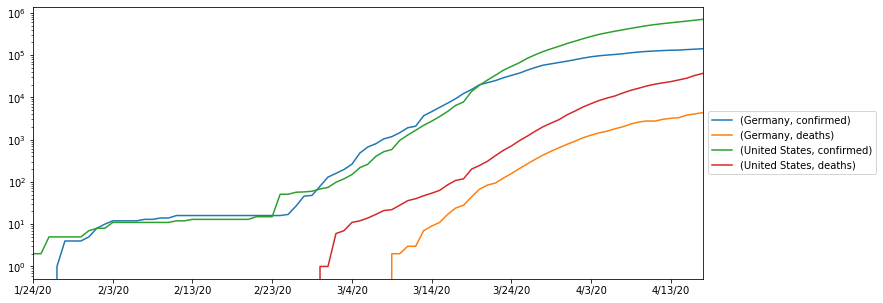

In [49]:
df_c[['confirmed','deaths']].stack().swaplevel(1,2).unstack()[['Germany','United States']].unstack().iloc[2::].plot.line(figsize=(12,5), logy=True).legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

creating 4x4 figure
(4, 4)


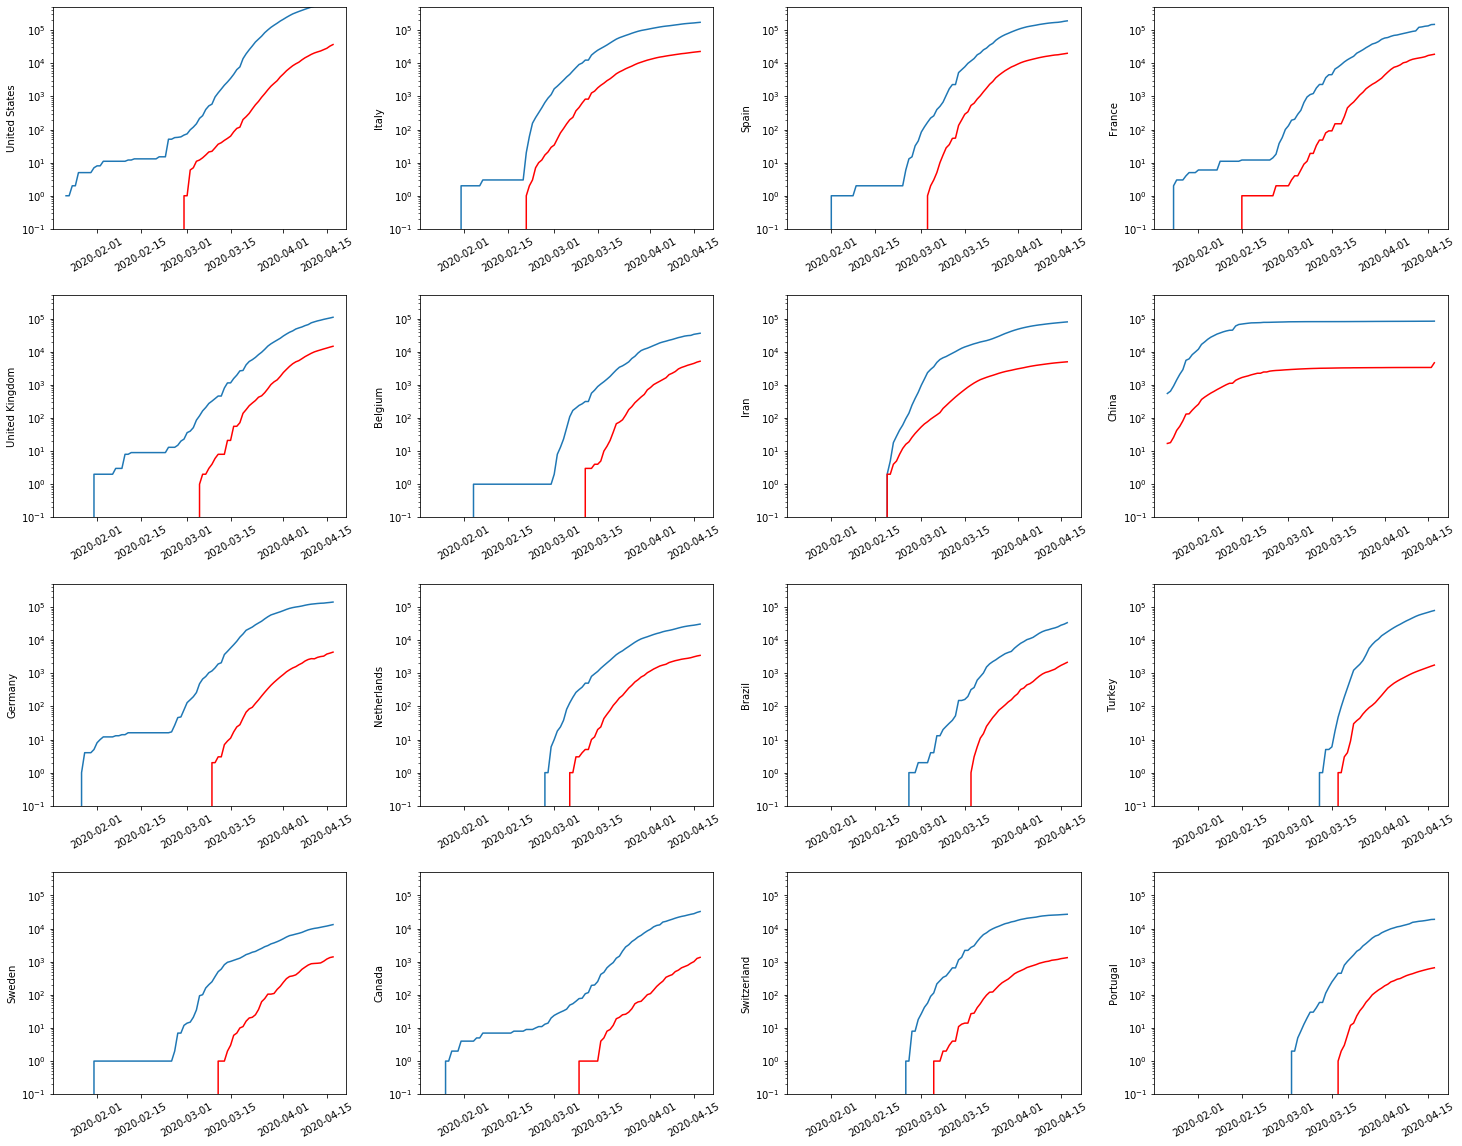

In [44]:
date_range = pd.date_range(
    df_tscg.index.levels[0][0], 
    df_tscg.index.levels[0][-1],
)
num_countries = len(top_25[0:16])
cols = 4
rows = int(num_countries/cols)
print("creating {0}x{1} figure".format(rows, cols))

# fig, axs = plt.subplots(rows, cols, sharey=True, figsize=(50,5 * rows))
fig, axs = plt.subplots(rows, cols, figsize=(25, 5 * rows))
print(axs.shape)
for rnum in range(rows):
    for cnum in range(cols):
        idx = (rnum * cols) + cnum
        x = date_range.values
        country = top_25[idx]
        data = df_c.stack().swaplevel(1,2).unstack()[country].unstack()
        yc = data['confirmed']
        yd = data['deaths']
#         yr = data['recovered']

        ax = axs[rnum, cnum]
        ax.set_yscale('log')
        
        ax.plot(x, yc, color='tab:blue', linestyle='{0}'.format('-'))
        ax.plot(x, yd, color='red', linestyle='-')
#         ax.plot(x, yr, color='tab:brown', linestyle='--')

        ax.set_ylim(
            bottom=0.1, 
            top=500000
        )
#         ax.set_xlim(left=date_range[0] + pd.DateOffset(-1), right=date_range[-1] + pd.DateOffset(1))
        ax.set_ylabel(country)
#         ax.set(title='{0} ({1}|{2})'.format(cid, last_apl, num_apl))
        for tick in ax.get_xticklabels():
            tick.set_rotation(30)
plt.subplots_adjust(hspace=0.30, wspace=0.25)
plt.savefig(os.path.join(OUT_DIR,'top16_countries.png'))

In [45]:
US_ANNUAL_DEATHS_2017 = [
    ("Heart disease", 647457),
    ("Cancer", 599108),
    ("Accidents", 169936),
#     ("Respiratory diseases", 160201),
    ("Stroke", 146383),
#     ("Alzheimers", 121404),
    ("Diabetes", 83564),
    ("Influenza", 55672),
#     ("Nephrosis", 50633),
#     ("Suicide", 47173),
]

US_ANNUAL_DEATHS_2_2017 = [
    ("Alcohol", 35823),
    ("Firearms", 39773),
    ("Drug OD", 73900),
]

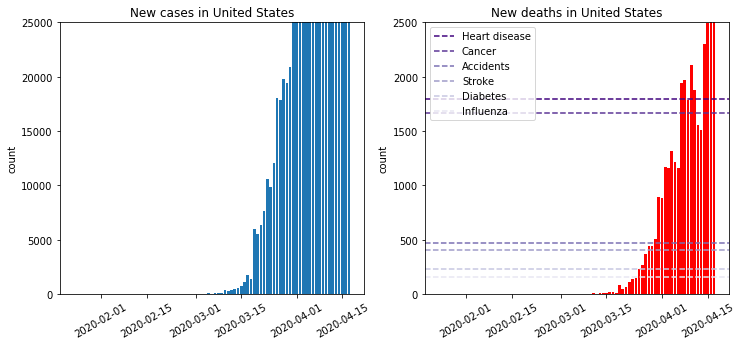

In [47]:
country = 'United States'
data = df_c.stack().swaplevel(1,2).unstack()[country].unstack().iloc[2::]
yc = data['new_confirmed']
yd = data['new_deaths']
x = date_range.values[2::]

fig, axs = plt.subplots(1,2,figsize=(12,5))
# axs[0].set_yscale('log')
axs[0].bar(x, yc, color='tab:blue')

axs[0].set_ylim(
    bottom=0, 
    top=25000
)
axs[0].set_title('New cases in {0}'.format(country))
axs[0].set_ylabel('count')
for tick in axs[0].get_xticklabels():
    tick.set_rotation(30)

# axs[1].set_yscale('log')
axs[1].bar(x, yd, color='red')
# axs[1].axhline(y=647457/360, color='y', ls='--', label='heart disease')
# axs[1].axhline(y=599108/360, color='orange', ls='--', label='cancer')
# axs[1].axhline(y=55602/360, color='purple', ls='--', label='influenza')
axs[1].set_ylim(
    bottom=0, 
    top=2500
)
cmap = matplotlib.cm.get_cmap(name='Purples')
dct = len(US_ANNUAL_DEATHS_2017)
idx = 0
for t in US_ANNUAL_DEATHS_2017:
    axs[1].axhline(y=t[1]/360, color=cmap((dct-idx)/dct), ls='--', label=t[0])
    idx += 1

axs[1].set_title('New deaths in {0}'.format(country))
axs[1].set_ylabel('count')
for tick in axs[1].get_xticklabels():
    tick.set_rotation(30)
  
handles, labels = axs[1].get_legend_handles_labels()
axs[1].legend(handles, labels, loc='upper left')

# handles, labels = axs[1].get_legend_handles_labels()
# fig.subplots_adjust(right=1.0)
# fig.legend(handles, labels, loc='center right', bbox_to_anchor=(.85, 0.8))


creating 4x4 figure
(4, 4)


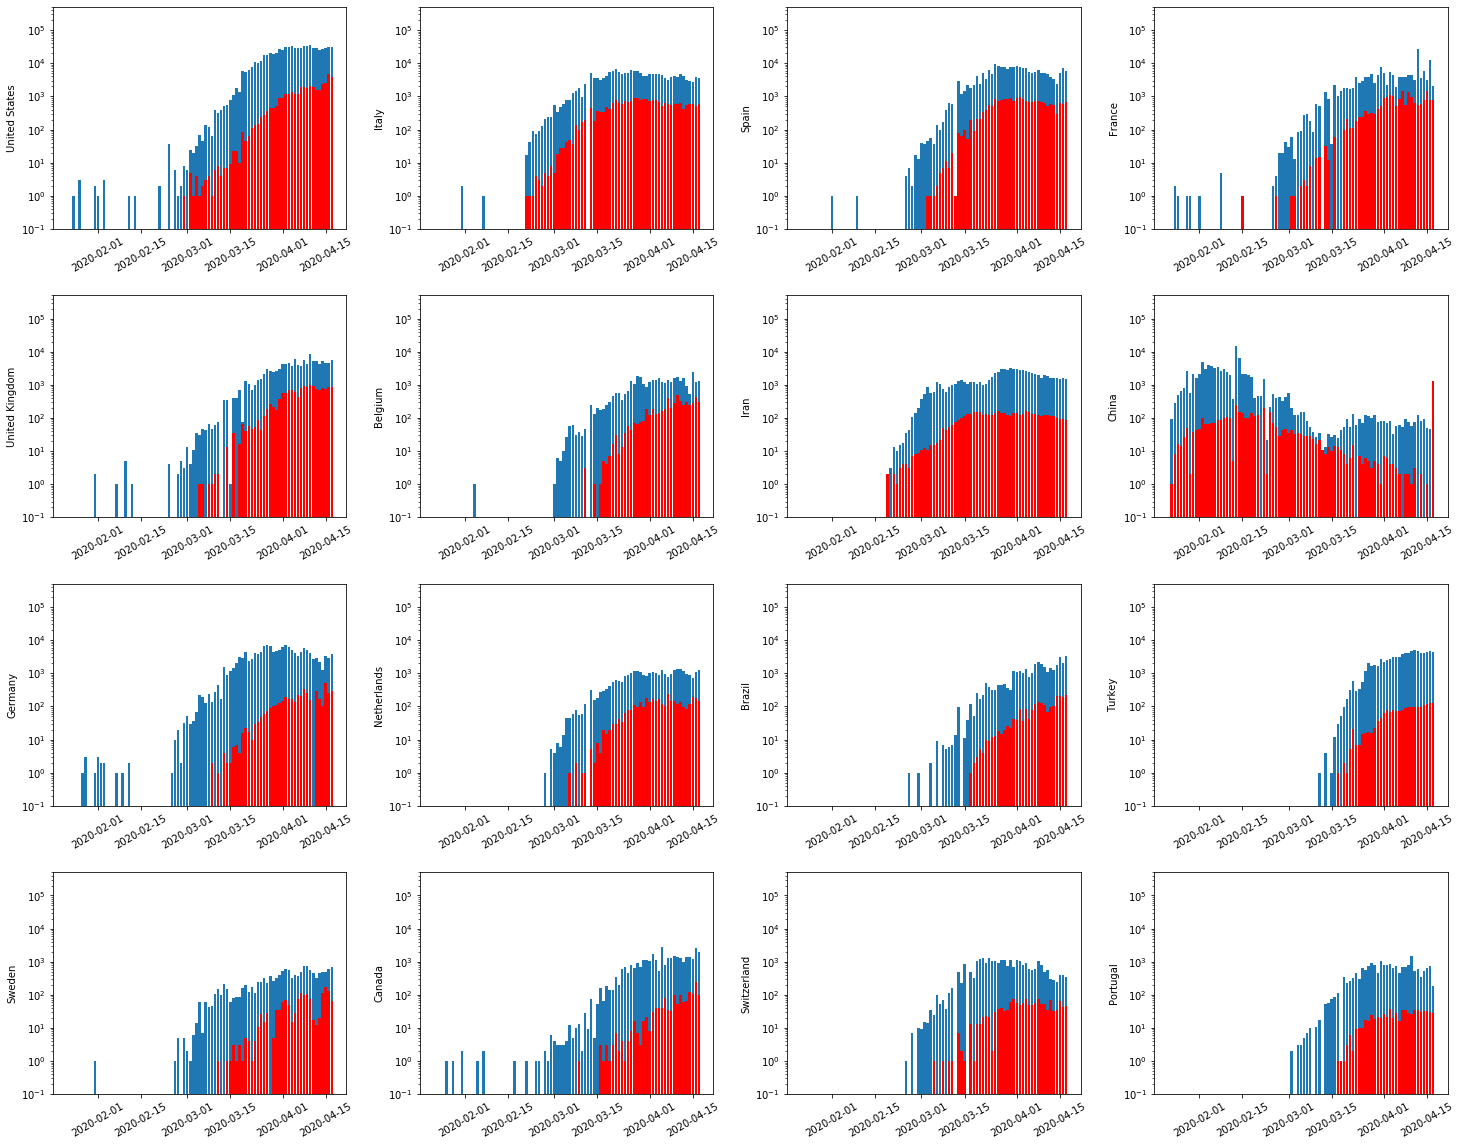

In [52]:
date_range = pd.date_range(
    df_tscg.index.levels[0][0], 
    df_tscg.index.levels[0][-1],
)
num_countries = len(top_25[0:16])
cols = 4
rows = int(num_countries/cols)
print("creating {0}x{1} figure".format(rows, cols))

# fig, axs = plt.subplots(rows, cols, sharey=True, figsize=(50,5 * rows))
fig, axs = plt.subplots(rows, cols, figsize=(25, 5 * rows))
print(axs.shape)
for rnum in range(rows):
    for cnum in range(cols):
        idx = (rnum * cols) + cnum
        x = date_range.values
        country = top_25[idx]
        data = df_c.stack().swaplevel(1,2).unstack()[country].unstack()
        yc = data['new_confirmed']
        yd = data['new_deaths']
#         yr = data['recovered']

        ax = axs[rnum, cnum]
        ax.set_yscale('log')
        
        ax.bar(x, yc, color='tab:blue')
        ax.bar(x, yd, color='red')
#         ax.plot(x, yr, color='tab:brown', linestyle='--')

        ax.set_ylim(
            bottom=0.1, 
            top=500000
        )
#         ax.set_xlim(left=date_range[0] + pd.DateOffset(-1), right=date_range[-1] + pd.DateOffset(1))
        ax.set_ylabel(country)
#         ax.set(title='{0} ({1}|{2})'.format(cid, last_apl, num_apl))
        for tick in ax.get_xticklabels():
            tick.set_rotation(30)
plt.subplots_adjust(hspace=0.30, wspace=0.25)
plt.savefig(os.path.join(OUT_DIR,'top16_countries.png'))